<a href="https://colab.research.google.com/github/MaayanHagbi/CAS_ADS_Final_Project/blob/main/Fraud_Detection_ML_(CAS_ADS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount Drive & Authenticate Google Big Query Access

In [1]:
#Import necessary modules for Google Colab to mount Google Drive and authenticate user
from google.colab import drive
from google.colab import auth

#Mount Google Drive and authenticate user to access Google services
drive.mount('/content/drive')
auth.authenticate_user()
print('Authenticated')

Mounted at /content/drive
Authenticated


#Load Packages

In [2]:
#Import necessary packages for Google BigQuery and data processing
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

#Install and import the geoip2 package for geolocation
!pip install geoip2
import geoip2.database

#Import additional packages for time management, machine learning, and data scaling
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import RobustScaler

#Clone Repository
!git clone https://github.com/MaayanHagbi/CAS_ADS_Final_Project

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 4.8 MB/s eta 0:00:00
Cloning into 'CAS_ADS_Final_Project'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 89 (delta 27), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (89/89), 1.02 MiB | 6.85 MiB/s, done.
Resolving deltas: 100% (27/27), done.


# Connect to Big Query and Get Data

In [3]:
#Set up Google BigQuery client with the specified project ID
project_id = 'total-biplane-387513'
bigquery_client = bigquery.Client(project = project_id)
#Fraud cases - (TC40/Safe -  run the model against Fraud cases only)!

#Query to select fraud and non-fraud cases from the dataset
Query = """
Select distinct * from (
Select * from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Clientinfo_id in (SELECT distinct Clientinfo_id FROM `total-biplane-387513.Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Is_fraud is not null)
union all
Select * from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Clientinfo_id in (
Select distinct Clientinfo_id from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Clientinfo_id not in (Select distinct Clientinfo_id from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Clientinfo_id in (SELECT distinct Clientinfo_id FROM `total-biplane-387513.Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Is_fraud is not null)) limit 5000));
"""
#perv limit:12869
#Validation set 2024
#Execute the query and convert the results to a Pandas DataFrame
Query_Results = bigquery_client.query(Query)
Data_Adf = Query_Results.to_dataframe()

#Remove duplicate records based on the 'id' column
Data_Adf = Data_Adf.drop_duplicates(subset=['id'])
Data_Adf

,id,transaction_sn,cluster_sn,amount,amount_gbp,ip,processor_timestamp,arn,recurring_sn,dispute_age,...,MCCs_id,MCCs_code,MCCs_description,MCCs_updated_at,MCCs_created_at,Accountmanager_id,Accountmanager_name,Accountmanager_updated_at,Accountmanager_created_at,Is_fraud
0,7839704,Oex174qz,jiCgR2GY,1.000000000,1.000000000,10.0.0.0,2023-03-29 11:55:33+00:00,74836953089358881336037,None,<NA>,...,4,5499,Miscellaneous Food Stores – Convenience Stores...,2022-11-13 15:38:59+00:00,NaT,643,Nakisha Syed-Lawton,2024-03-27 13:16:02+00:00,NaT,None
1,8945727,LzF0Kasv,g32eJSYX,600.000000000,474.720000000,188.236.226.251,2023-07-22 00:34:53+00:00,74405243203328672781632,None,<NA>,...,2,7995,"Betting (including Lottery Tickets, Casino Gam...",2023-04-17 09:27:00+00:00,NaT,23,Hai Shmool,2020-04-18 23:08:37+00:00,NaT,None
2,8194290,gomEXDSp,BiKs5Ffd,70.000000000,60.010000000,2a02:810b:4840:2cb3:a0bf:d4bb:a458:91d3,2023-05-05 14:10:23+00:00,74405243125317442710000,None,<NA>,...,2,7995,"Betting (including Lottery Tickets, Casino Gam...",2023-04-17 09:27:00+00:00,NaT,23,Hai Shmool,2020-04-18 23:08:37+00:00,NaT,None
3,8194359,bAFgjbAI,r5OI4i4X,70.000000000,60.010000000,2a02:810b:4840:2cb3:a0bf:d4bb:a458:91d3,2023-05-05 14:17:56+00:00,74405243125317442710018,None,<NA>,...,2,7995,"Betting (including Lottery Tickets, Casino Gam...",2023-04-17 09:27:00+00:00,NaT,23,Hai Shmool,2020-04-18 23:08:37+00:00,NaT,None
4,11239481,JCZHfyTy,1n7db0gs,5.000000000,4.290000000,83.76.108.22,2024-03-25 12:45:58+00:00,85301164085412565673627,None,<NA>,...,24,7273,Dating & Escort Services,2022-11-13 15:51:44+00:00,NaT,643,Nakisha Syed-Lawton,2024-03-27 13:16:02+00:00,NaT,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28564,8868317,gKXs7nec,89dhHZoi,31.930000000,27.400000000,2a02:1388:215e:bb89::4883:f369,2023-07-15 11:09:47+00:00,None,None,<NA>,...,4,5499,Miscellaneous Food Stores – Convenience Stores...,2022-11-13 15:38:59+00:00,NaT,<NA>,None,NaT,NaT,None
28565,10655984,JuuWePRz,cmnUtqMl,39.430000000,33.840000000,2a01:e0a:a93:33d0:bd75:aaa3:8805:5b10,2024-01-20 01:03:24+00:00,None,None,<NA>,...,4,5499,Miscellaneous Food Stores – Convenience Stores...,2022-11-13 15:38:59+00:00,NaT,<NA>,None,NaT,NaT,FR
28566,8471616,Fa4shOO6,QKIfRxp2,98.830000000,84.820000000,2a02:85f:f510:8e00:a019:861c:d4ce:74eb,2023-06-05 17:10:22+00:00,None,None,<NA>,...,4,5499,Miscellaneous Food Stores – Convenience Stores...,2022-11-13 15:38:59+00:00,NaT,<NA>,None,NaT,NaT,None
28567,7717618,4FbelUsy,SzwlSlDb,85.480000000,73.280000000,46.103.79.223,2023-03-16 14:53:53+00:00,None,None,<NA>,...,4,5499,Miscellaneous Food Stores – Convenience Stores...,2022-11-13 15:38:59+00:00,NaT,<NA>,None,NaT,NaT,None


#Check whether there are any duplicate ID's

In [4]:
duplicate_rows = Data_Adf[Data_Adf.duplicated(subset=['id'])]
duplicate_rows

,id,transaction_sn,cluster_sn,amount,amount_gbp,ip,processor_timestamp,arn,recurring_sn,dispute_age,...,MCCs_id,MCCs_code,MCCs_description,MCCs_updated_at,MCCs_created_at,Accountmanager_id,Accountmanager_name,Accountmanager_updated_at,Accountmanager_created_at,Is_fraud


#Conversion and Creation of Variables

In [5]:
#Function to convert columns to float type
def convert_float(columns):
  for col in columns:
    Data_Adf[col] = pd.to_numeric(Data_Adf[col],errors='coerce')

#Function to convert columns to string type
def convert_string(columns):
  for col in columns:
    Data_Adf[col] = Data_Adf[col].astype(str)

#Define columns to be converted to string and float
columns_to_string = ['id']
columns_to_float = ['amount_gbp']

#Convert specified columns to float and string types
convert_float(columns_to_float)
convert_string(columns_to_string)

#Replace 'None' with a placeholder value & map string values to boolean values
Data_Adf['Is_fraud'] = Data_Adf['Is_fraud'].fillna('Missing')
Data_Adf['Is_fraud'] = Data_Adf['Is_fraud'].map({'Missing': False, 'FR': True})

#Data Analysis

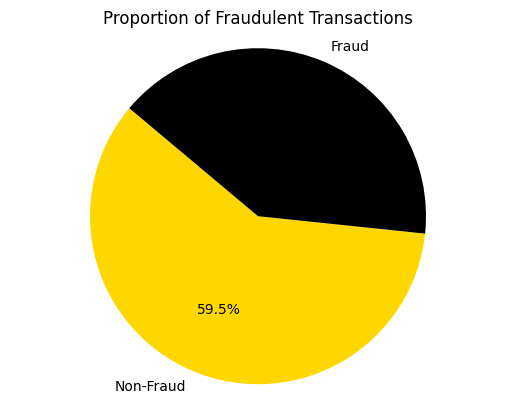

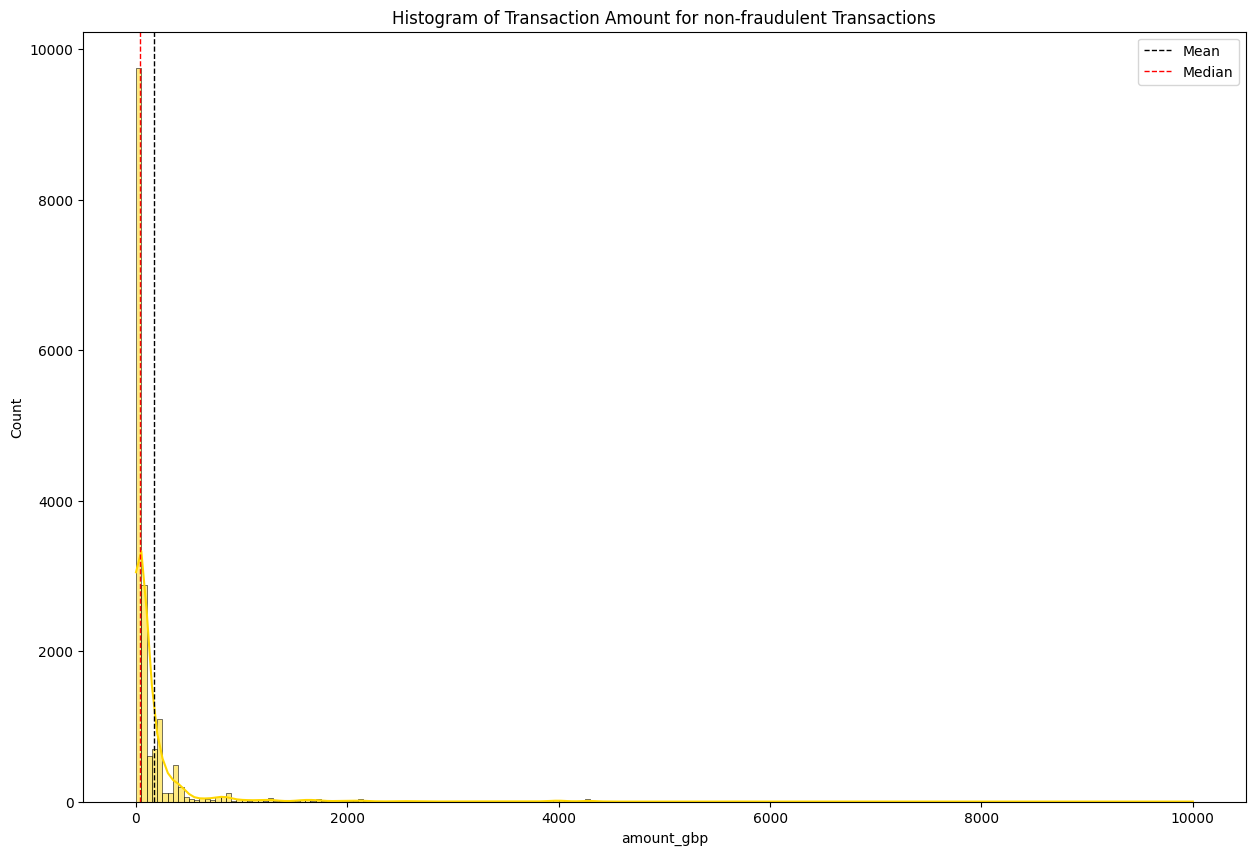

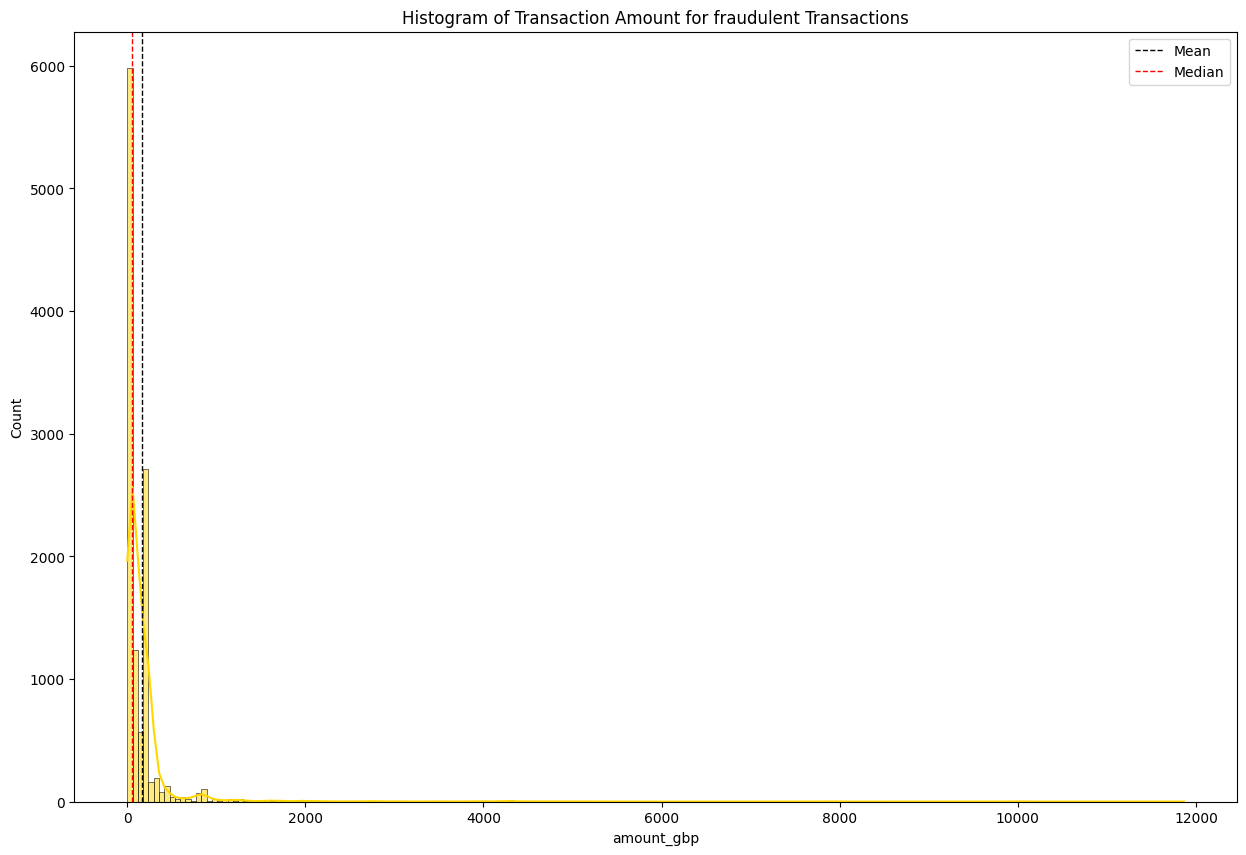

In [6]:
#Visualization of share of fraudulent vs. non-fraudulent transactions (trx) using a pie chart
Data_Adf["Is_fraud"].value_counts().plot.pie(labels=['Non-Fraud','Fraud'],colors=['gold','black'], autopct='%1.1f%%',startangle=140,textprops={'color':"black"})
plt.title('Proportion of Fraudulent Transactions')
plt.ylabel('')
plt.axis('equal')
plt.show()

#Check the amount distribution of fraudulent vs. non-fraudulent trx
fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==True]
non_fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==False]

#Plotting of histogram of transaction amount for non-fraudulent transactions
plt.figure(figsize=(15,10))
plt.title("Histogram of Transaction Amount for non-fraudulent Transactions")
sns.histplot(non_fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black', bins=200)
mean_value = np.mean(non_fraudulent_df["amount_gbp"])
median_value = np.median(non_fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median_value, color='red', linestyle='dashed', linewidth=1, label='Median')
plt.legend()
plt.show()

#Plotting of histogram of transaction amount for fraudulent transactions
plt.figure(figsize=(15,10))
plt.title("Histogram of Transaction Amount for fraudulent Transactions")
sns.histplot(fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black', bins=200)
mean_value = np.mean(fraudulent_df["amount_gbp"])
median_value = np.median(fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median_value, color='red', linestyle='dashed', linewidth=1, label='Median')
plt.legend()
plt.show()

#Generate Customer Profiles (Cust_Profiles)

In [7]:
#Calcualte Customer Profile Statistics: mean, median and standard deviation of transaction amount per client
cust_profiles = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].agg(['mean','median']).reset_index()
cust_profiles.columns = ['client_id','cust_profiles_mean_gbp_amount','cust_profiles_median_gbp_amount']
cust_profiles_std = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].std(ddof=0).reset_index()
cust_profiles_std.columns = ['client_id','cust_profiles_std_gbp_amount']

#Calcualte Average Number of trx per day per customer
Data_Adf['timestamp'] = pd.to_datetime(Data_Adf['timestamp'],errors='coerce')
trx_per_day_per_customer = Data_Adf.groupby(['Clientinfo_id', Data_Adf['timestamp'].dt.date]).size().reset_index(name='num_transactions')
mean_nb_trx_per_day = trx_per_day_per_customer.groupby('Clientinfo_id')['num_transactions'].mean().reset_index()
mean_nb_trx_per_day.columns = ['client_id','cust_profiles_mean_nb_trx_per_day']

#Merge datasets to combine customer profile statistics
Cust_Profiles = pd.merge(cust_profiles,cust_profiles_std,on='client_id')
Cust_Profiles = pd.merge(cust_profiles,mean_nb_trx_per_day,on='client_id')
Cust_Profiles

,client_id,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,1058555,53.65,53.65,1.0
1,1058557,53.65,53.65,1.0
2,1058561,37.64,37.64,1.0
3,1058568,157.75,157.75,1.0
4,1058569,157.75,157.75,1.0
...,...,...,...,...
15347,4637786,80.07,80.07,1.0
15348,4638560,85.40,85.40,1.0
15349,4639367,31.23,31.23,1.0
15350,4639822,77.66,77.66,1.0


# Get Customer Country from IP Address / Card Info (Cust_Country_Profile)

In [8]:
#Function to get country information from an IP address
def get_country(ip):
    mmdb_file_path = '/content/drive/MyDrive/CAS_Final_Project/GeoLite2-City.mmdb'

    if pd.notna(ip) and ip != 'nan':
        try:
            with geoip2.database.Reader(mmdb_file_path) as reader:
                response = reader.city(ip)

                country_name = response.country.name
                country_iso_code = response.country.iso_code
                return country_name, country_iso_code
        except Exception as e:
            return 0, 0
    else:
        return 0, 0

#Read country latitude and longitude data from a CSV file
df_Country_lan_lat = pd.read_csv("/content/drive/MyDrive/CAS_Final_Project/Country_lan_lat.csv",sep=';')

In [9]:
#Get Customer Device IP coordinates (country) and use get_country function to get country information
Cust_Country_Profile_Ip = Data_Adf[['id','Clientinfo_id','Deviceinfo_ip']].copy()
Cust_Country_Profile_Ip['Deviceinfo_ip'] = Cust_Country_Profile_Ip['Deviceinfo_ip'].astype(str)
Cust_Country_Profile_Ip[['country_name','country']] = Cust_Country_Profile_Ip['Deviceinfo_ip'].apply(lambda x:  pd.Series(get_country(x)))

#Merge country information with latitude and longitude data
merge_df = pd.merge(Cust_Country_Profile_Ip,df_Country_lan_lat,on='country',how='left')

#Select relevant columns and rename them
columns_to_keep = ['id','Clientinfo_id','latitude','longitude']
Cust_Country_Profile_Ip = merge_df[columns_to_keep]
old_colums_names = ['id','Clientinfo_id','latitude','longitude']
new_columns_names = ['id','client_id','latitude_ip','longitude_ip']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Cust_Country_Profile_Ip = Cust_Country_Profile_Ip.rename(columns=new_columns_dic)
Cust_Country_Profile_Ip

,id,client_id,latitude_ip,longitude_ip
0,7839704,3315777,31.046051,34.851612
1,8945727,3759645,29.311660,47.481766
2,8194290,3500954,51.165691,10.451526
3,8194359,3500954,51.165691,10.451526
4,11239481,4178993,46.818188,8.227512
...,...,...,...,...
28563,8868317,3734121,39.074208,21.824312
28564,10655984,4284960,46.227638,2.213749
28565,8471616,2954115,39.074208,21.824312
28566,7717618,2961976,39.074208,21.824312


In [10]:
#Get customer card issuer bank coordinates (country)
Card_Info_Country_Profile = Data_Adf[['id','Clientinfo_id','Countries_iso2']].copy()

#Fill NaN values with 0 and rename column for consistency
Card_Info_Country_Profile = Card_Info_Country_Profile.fillna(0)
old_colums_names = ['Countries_iso2']
new_columns_names = ['country']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Card_Info_Country_Profile = Card_Info_Country_Profile.rename(columns=new_columns_dic)

#Merge country information with latitude and longitude data
merge_df = pd.merge(Card_Info_Country_Profile,df_Country_lan_lat,on='country',how='left')

#Select relevant columns and rename them
columns_to_keep = ['id','Clientinfo_id','latitude','longitude']
Card_Info_Country_Profile = merge_df[columns_to_keep]
old_colums_names = ['id','Clientinfo_id','latitude','longitude']
new_columns_names = ['id','client_id','latitude_card','longitude_card']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Card_Info_Country_Profile = Card_Info_Country_Profile.rename(columns=new_columns_dic)
Card_Info_Country_Profile

,id,client_id,latitude_card,longitude_card
0,7839704,3315777,31.046051,34.851612
1,8945727,3759645,29.311660,47.481766
2,8194290,3500954,49.815273,6.129583
3,8194359,3500954,49.815273,6.129583
4,11239481,4178993,46.818188,8.227512
...,...,...,...,...
28563,8868317,3734121,39.074208,21.824312
28564,10655984,4284960,46.227638,2.213749
28565,8471616,2954115,39.074208,21.824312
28566,7717618,2961976,39.074208,21.824312


In [11]:
#Merge country profiles based on ID
merge_df = pd.merge(Cust_Country_Profile_Ip,Card_Info_Country_Profile,how = 'left', on='id')

#Select relevant columns and rename them
columns_to_keep = ['id', 'client_id_x', 'latitude_ip', 'longitude_ip','latitude_card', 'longitude_card']
Cust_Country_Profile = merge_df[columns_to_keep]
Cust_Country_Profile.columns
old_colums_names = ['id', 'client_id_x', 'latitude_ip', 'longitude_ip', 'latitude_card','longitude_card']
new_columns_names = ['id', 'client_id', 'latitude_ip', 'longitude_ip', 'latitude_card','longitude_card']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Cust_Country_Profile = Cust_Country_Profile.rename(columns=new_columns_dic)

#Set 'id' column as index and convert it to integer type
Cust_Country_Profile.set_index('id',inplace=True)
Cust_Country_Profile.index = Cust_Country_Profile.index.astype(int)
Cust_Country_Profile

,client_id,latitude_ip,longitude_ip,latitude_card,longitude_card
id,,,,,
7839704,3315777,31.046051,34.851612,31.046051,34.851612
8945727,3759645,29.311660,47.481766,29.311660,47.481766
8194290,3500954,51.165691,10.451526,49.815273,6.129583
8194359,3500954,51.165691,10.451526,49.815273,6.129583
11239481,4178993,46.818188,8.227512,46.818188,8.227512
...,...,...,...,...,...
8868317,3734121,39.074208,21.824312,39.074208,21.824312
10655984,4284960,46.227638,2.213749,46.227638,2.213749
8471616,2954115,39.074208,21.824312,39.074208,21.824312


# Get Transaction Profile (Trx_Profile)

In [12]:
#Function to convert time to seconds
def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

#Function to check if a date is a weekend
def is_weekend(date):
    return date.weekday() >= 5

#Function to calculate client spending behavior features over various rolling window sizes of customer transactions
def get_client_spending_behaviour_features(customer_trx, window_size_in_days = [1,7,30]):

  customer_trx = customer_trx.sort_values('timestamp')
  customer_trx.index = customer_trx.timestamp

  for window_size in window_size_in_days:
    sum_amount_trx_window = customer_trx['amount_gbp'].rolling(str(window_size)+'d').sum()
    nb_trx_window = customer_trx['amount_gbp'].rolling(str(window_size) + 'd').count()

    avg_amount_trx_window = sum_amount_trx_window/nb_trx_window

    customer_trx['client_nb_trx_' + str(window_size) + 'day_window'] = list(nb_trx_window)
    customer_trx['client_avg_amount_'+str(window_size) + 'day_window'] = list(avg_amount_trx_window)

  customer_trx.index = customer_trx.id

  return customer_trx

#Trx Profiles table
Trx_Profile = Data_Adf[['id','timestamp','Clientinfo_id','amount_gbp']].copy()
Trx_Profile.loc[:,'time'] = Trx_Profile['timestamp'].dt.time
Trx_Profile.loc[:,'trx_time_seconds'] = Trx_Profile['time'].apply(lambda x: time_to_seconds(x))
Trx_Profile.loc[:,'date'] = Trx_Profile['timestamp'].dt.date
Trx_Profile.loc[:,'is_WKE?'] = Trx_Profile['date'].apply(lambda x: is_weekend(x)).astype(int)

target_time = pd.to_datetime('22:00:00').time()
Trx_Profile.loc[:,'is_night?'] = (Trx_Profile['time'] > target_time).astype(int)

#Drop unnecessary columns and rename
columns_to_drop = ['time','date']
Trx_Profile = Trx_Profile.drop(columns=columns_to_drop)
old_colums_names = Trx_Profile.columns
new_columns_names = ['id','timestamp','client_id','trx_amount_gbp','trx_time_seconds','trx_is_weekend']
new_columns_dic = {k: v for k, v in zip(old_colums_names,new_columns_names)}
Trx_Profile = Trx_Profile.rename(columns=new_columns_dic)

#Set 'id' column as index and convert it to integer type
Trx_Profile.set_index('id',inplace=True)
Trx_Profile.index = Trx_Profile.index.astype(int)
Trx_Profile

,timestamp,client_id,trx_amount_gbp,trx_time_seconds,trx_is_weekend,is_night?
id,,,,,,
7839704,2023-03-29 11:55:34+00:00,3315777,1.00,42934,0,0
8945727,2023-07-22 00:34:56+00:00,3759645,474.72,2096,1,0
8194290,2023-05-05 14:10:27+00:00,3500954,60.01,51027,0,0
8194359,2023-05-05 14:17:59+00:00,3500954,60.01,51479,0,0
11239481,2024-03-25 12:46:01+00:00,4178993,4.29,45961,0,0
...,...,...,...,...,...,...
8868317,2023-07-15 11:09:48+00:00,3734121,27.40,40188,1,0
10655984,2024-01-20 01:03:25+00:00,4284960,33.84,3805,1,0
8471616,2023-06-05 17:10:23+00:00,2954115,84.82,61823,0,0


# Get Customer Behavoiur Profile (Trx_Profile_Rolling)

In [13]:
#Customer Behaviour Profile
Trx_Profile_Rolling = Data_Adf[['id','timestamp','Clientinfo_id','amount_gbp']].copy()

#Convert timestamp to datetime without timezone
Trx_Profile_Rolling['timestamp'] = Trx_Profile_Rolling['timestamp'].dt.tz_localize(None)
Trx_Profile_Rolling['timestamp'] = Trx_Profile_Rolling['timestamp'].astype('datetime64[ns]')

#Sort the DataFrame by timestamp and client ID
Trx_Profile_Rolling = Trx_Profile_Rolling.sort_values(['timestamp','Clientinfo_id'], ascending=[True,True],ignore_index=True)

#Apply the previously defined function to calculate customer spending behavior features
%time Trx_Profile_Rolling = Trx_Profile_Rolling.groupby('Clientinfo_id').apply(lambda x: get_client_spending_behaviour_features(x))

#Set 'id' column as index and convert it to integer type
Trx_Profile_Rolling.set_index('id',inplace=True)
Trx_Profile_Rolling.index = Trx_Profile_Rolling.index.astype(int)
Trx_Profile_Rolling

CPU times: user 1min 11s, sys: 1.25 s, total: 1min 12s
Wall time: 1min 12s


,timestamp,Clientinfo_id,amount_gbp,client_nb_trx_1day_window,client_avg_amount_1day_window,client_nb_trx_7day_window,client_avg_amount_7day_window,client_nb_trx_30day_window,client_avg_amount_30day_window
id,,,,,,,,,
1983485,2021-01-01 00:01:07,1058555,53.65,1.0,53.65,1.0,53.65,1.0,53.65
1983490,2021-01-01 00:08:21,1058557,53.65,1.0,53.65,1.0,53.65,1.0,53.65
1983501,2021-01-01 00:22:02,1058561,37.64,1.0,37.64,1.0,37.64,1.0,37.64
1983522,2021-01-01 00:37:17,1058568,157.75,1.0,157.75,1.0,157.75,1.0,157.75
1983524,2021-01-01 00:38:50,1058569,157.75,1.0,157.75,1.0,157.75,1.0,157.75
...,...,...,...,...,...,...,...,...,...
11575099,2024-04-29 13:22:14,4637786,80.07,1.0,80.07,1.0,80.07,1.0,80.07
11577553,2024-04-29 16:43:17,4638560,85.40,1.0,85.40,1.0,85.40,1.0,85.40
11579306,2024-04-29 20:39:38,4639367,31.23,1.0,31.23,1.0,31.23,1.0,31.23


# Get Merchant Brand Profile (Brand_Fraud_Profile)

In [14]:
#Function to calculate spending behavior features of a brand over various rolling window sizes of customer transactions
def get_count_risk_rolling_window(terminal_trx, delay_period = 7, windows_size_in_days = [1, 7, 30], feature = "Terminal_ID"):

  terminal_trx = terminal_trx.sort_values('timestamp')
  terminal_trx.index = terminal_trx.timestamp

  for window_size in windows_size_in_days:
   sum_amount_fraud_trx_window = terminal_trx['amount_gbp_fraud_trx'].rolling(str(window_size) + 'd').sum()
   nb_fraud_trx_window = terminal_trx['amount_gbp_fraud_trx'].rolling(str(window_size) + 'd').count()

   avg_amount_fraud_trx = sum_amount_fraud_trx_window / nb_fraud_trx_window

   terminal_trx['brand_fraud_nb_trx_' + str(window_size) + 'day_window'] = list(nb_fraud_trx_window)
   terminal_trx['brand_fraud_avg_amount_'+str(window_size) + 'day_window'] = list(avg_amount_fraud_trx)

  terminal_trx.index = terminal_trx.id

  return terminal_trx

#Create a new column for fraudulent transaction amounts
Data_Adf['amount_gbp_fraud_trx'] = Data_Adf['amount_gbp'].where(Data_Adf['Is_fraud'], np.nan)

#Extract relevant columns for Brand Fraud Profile
Brand_Fraud_Profile = Data_Adf[['id','timestamp','Brands_id','amount_gbp_fraud_trx']].copy()

#Convert timestamp to datetime without timezone
Brand_Fraud_Profile['timestamp'] = Brand_Fraud_Profile['timestamp'].dt.tz_localize(None)
Brand_Fraud_Profile['timestamp'] = Brand_Fraud_Profile['timestamp'].astype('datetime64[ns]')

#Sort the DataFrame by timestamp and brand ID
Brand_Fraud_Profile = Brand_Fraud_Profile.sort_values(['timestamp','Brands_id'], ascending=[True,True],ignore_index=True)

#Apply the previously defined function to calculate brand fraud profile features
%time Brand_Fraud_Profile = Brand_Fraud_Profile.groupby('Brands_id').apply(lambda x: get_count_risk_rolling_window(x))

#Set 'id' column as index and convert it to integer type
Brand_Fraud_Profile.set_index('id',inplace=True)
Brand_Fraud_Profile.index = Brand_Fraud_Profile.index.astype(int)

#Drop the 'amount_gbp_fraud_trx' column
Brand_Fraud_Profile = Brand_Fraud_Profile.drop('amount_gbp_fraud_trx', axis=1)
Brand_Fraud_Profile

CPU times: user 1.71 s, sys: 19.8 ms, total: 1.73 s
Wall time: 1.76 s


,timestamp,Brands_id,brand_fraud_nb_trx_1day_window,brand_fraud_avg_amount_1day_window,brand_fraud_nb_trx_7day_window,brand_fraud_avg_amount_7day_window,brand_fraud_nb_trx_30day_window,brand_fraud_avg_amount_30day_window
id,,,,,,,,
1989686,2021-01-02 18:18:00,1234,1.0,53.65,1.0,53.65,1.0,53.65
1989927,2021-01-02 18:57:12,1234,1.0,53.65,1.0,53.65,1.0,53.65
1999498,2021-01-04 21:42:57,1234,1.0,157.75,2.0,105.70,2.0,105.70
2001827,2021-01-05 09:31:50,1234,2.0,105.70,3.0,88.35,3.0,88.35
2061007,2021-01-06 10:21:23,1234,0.0,NaN,3.0,88.35,3.0,88.35
...,...,...,...,...,...,...,...,...
11563869,2024-04-28 07:12:55,851569,0.0,NaN,0.0,NaN,0.0,NaN
11563941,2024-04-28 07:19:16,851569,0.0,NaN,0.0,NaN,0.0,NaN
11580863,2024-04-30 05:58:52,851569,0.0,NaN,0.0,NaN,0.0,NaN


In [15]:
abc = Trx_Profile_Rolling.copy()
xyz = Brand_Fraud_Profile.copy()

abc = abc.reset_index(level='id') #Key is id
xyz = xyz.reset_index(level='id') #Key is id

# Convert 'id' column to sets for faster comparison
id_set1 = set(abc['id'])
id_set2 = set(xyz['id'])

# Find missing IDs in df2
missing_ids = id_set1 - id_set2

print("Missing IDs in df2:", missing_ids)


Missing IDs in df2: set()


# Get All Dummy Variables (Data_Dummies)

In [16]:
#Creating a copy of the original data frame with the needed columns
Data_Dummies = Data_Adf[['id','Currency_name','Environments_name','Brands_name','Deviceinfo_device_name','Deviceinfo_browser_name','Clientinfo_email','Paymentbrands_name','Issuers_name','Industries_name','Companies_name','Processors_name']].copy()

#Extract email domain
Data_Dummies['Email_domain'] = Data_Dummies['Clientinfo_email'].str.split('@').str[1].str.split('.').str[0]
Data_Dummies = Data_Dummies.replace(' ', '_', regex=True)

#Creating dummy variables for categorical columns, dropping email column and converting columns to integer type
Data_Dummies = pd.get_dummies(Data_Dummies,columns=['Currency_name','Environments_name','Brands_name','Deviceinfo_device_name','Deviceinfo_browser_name','Email_domain','Paymentbrands_name','Issuers_name','Industries_name','Companies_name','Processors_name'])
Data_Dummies = Data_Dummies.drop(columns='Clientinfo_email')
Data_Dummies = Data_Dummies.astype(int)

# Set 'id' column as index
Data_Dummies.set_index('id', inplace=True)
Data_Dummies

,Currency_name_AUD,Currency_name_CAD,Currency_name_CHF,Currency_name_DKK,Currency_name_EUR,Currency_name_GBP,Currency_name_ILS,Currency_name_INR,Currency_name_MYR,Currency_name_USD,...,Processors_name_ABS,Processors_name_CCD,Processors_name_CTM,Processors_name_ECP,Processors_name_ITG,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN
id,,,,,,,,,,,,,,,,,,,,,
7839704,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8945727,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
8194290,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8194359,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
11239481,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8868317,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10655984,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8471616,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Merge all Datasets into a Single Dataset

In [17]:
#Rest indexs in all dataframes in preparation to merge
Cust_Country_Profile = Cust_Country_Profile.reset_index(level='id') #Key is id
Trx_Profile = Trx_Profile.reset_index(level='id') #Key is id
Trx_Profile_Rolling = Trx_Profile_Rolling.reset_index(level='id') #Key is id
Brand_Fraud_Profile = Brand_Fraud_Profile.reset_index(level='id') #Key is id

In [18]:
#Extract fraud flag column and convert to integer type
DF_Flag = Data_Adf[['id', 'Is_fraud']]
DF_Flag.loc[:, 'id'] = DF_Flag['id'].astype(int)
DF_Flag.loc[:, 'Is_fraud'] = DF_Flag['Is_fraud'].astype(int)

#Add the previously newly created attributes to the id and fraud flag dataset with a merge
DF = pd.merge(Cust_Country_Profile, DF_Flag, how='left', on='id')
DF1 = pd.merge(DF, Trx_Profile, how='left', on='id')
DF2 = pd.merge(DF1, Trx_Profile_Rolling,how='left',on='id')
DF3 = pd.merge(DF2, Brand_Fraud_Profile,how='left',on='id')
DF4 = pd.merge(DF3, Cust_Profiles, how='left', left_on='client_id_x', right_on='client_id')

##only when Testing With Full Dataset

In [19]:
#Add the dummies dataset with a merge
DF5 = pd.merge(DF4, Data_Dummies, how='left', on='id')

##only when Testing Without Profiles

In [20]:
#Merge the previously newly created dummy variables to the id and fraud flag dataset with a merge
DF_x = pd.merge(Data_Dummies, DF_Flag, how='left', on='id')

# Balancing Dataset

In [22]:
#Selecting subset with fraudulent and non-fraudulent trx and removing duplicate rows based on the 'id' column
#For Testing Without Dummies & Coordinates (_wodc)
ones_subset_wodc = DF4.loc[DF4["Is_fraud"] == 1]
zeros_subset_wodc = DF4.loc[DF4["Is_fraud"] == 0]
#For Testing Without Profiles (_wop)
ones_subset_wop = DF_x.loc[DF_x["Is_fraud"] == 1]
zeros_subset_wop = DF_x.loc[DF_x["Is_fraud"] == 0]
#For Testing With Full Dataset (_fd)
ones_subset_fd = DF5.loc[DF5["Is_fraud"] == 1]
zeros_subset_fd = DF5.loc[DF5["Is_fraud"] == 0]

#Count the number of non-null values & Sample null values to match the number of non-null values
number_of_ones_wodc = len(ones_subset_wodc)
sampled_zeros_wodc = zeros_subset_wodc.sample(number_of_ones_wodc, random_state=42)
number_of_ones_wop = len(ones_subset_wop)
sampled_zeros_wop = zeros_subset_wop.sample(number_of_ones_wop, random_state=42)
number_of_ones_fd = len(ones_subset_fd)
sampled_zeros_fd = zeros_subset_fd.sample(number_of_ones_fd, random_state=42)

#Concatenate the sampled null values with the non-null values
balanced_df_wodc = pd.concat([ones_subset_wodc, sampled_zeros_wodc], ignore_index=True)
balanced_df_wop = pd.concat([ones_subset_wop, sampled_zeros_wop], ignore_index=True)
balanced_df_fd = pd.concat([ones_subset_fd, sampled_zeros_fd], ignore_index=True)

#Copy Dataset & account for Null Values
DS_wodc = balanced_df_wodc.copy()
DS_wodc.replace('<NA>', np.nan, inplace=True)
DS_wop = balanced_df_wop.copy()
DS_wop.replace('<NA>', np.nan, inplace=True)
DS_fd = balanced_df_fd.copy()
DS_fd.replace('<NA>', np.nan, inplace=True)

#Splitting into Training, Test, and Validation Set

In [44]:
# Define the start and end dates for each split
train_start_date = '1970-01-01'
train_end_date = '2023-10-31'
test_start_date = '2023-11-01'
test_end_date = '2024-01-31'
val_start_date = '2024-02-01'
val_end_date = DS_wodc['timestamp'].max()

##Only run one of the following three:

###when Testing With Full Dataset

In [45]:
# Convert the "timestamp" column to datetime if it's not already in datetime format
DS_fd['timestamp'] = pd.to_datetime(DS_fd['timestamp'])

# Perform the split based on timestamp
train_set = DS_fd[(DS_fd['timestamp'] >= train_start_date) & (DS_fd['timestamp'] <= train_end_date)]
test_set = DS_fd[(DS_fd['timestamp'] >= test_start_date) & (DS_fd['timestamp'] <= test_end_date)]
val_set = DS_fd[(DS_fd['timestamp'] >= val_start_date) & (DS_fd['timestamp'] <= val_end_date)]

# Check the lengths of each set
print("Train set length:", len(train_set))
print("Test set length:", len(test_set))
print("Validation set length:", len(val_set))

#Gather columns containing ID's, timestamps and others to drop in a list and drop them to prepare the final dataframe
column_ids = [col for col in train_set.columns if '_id' in col]
column_timestamp = [col for col in train_set.columns if 'timestamp' in col]
dropcolumns = column_ids + column_timestamp + ['id'] + ['trx_amount_gbp']

# Apply the same drop operation to all sets
train = train_set.drop(columns=dropcolumns)
test = test_set.drop(columns=dropcolumns)
val = val_set.drop(columns=dropcolumns)

# Print or use these DataFrames as needed
print("Train set after dropping columns:", train)
print("Test set after dropping columns:", test)
print("Validation set after dropping columns:", val)

Train set length: 18629
Test set length: 2349
Validation set length: 2120
Train set after dropping columns:        latitude_ip  longitude_ip  latitude_card  longitude_card  Is_fraud  \
1              NaN           NaN            NaN             NaN         1   
2              NaN           NaN            NaN             NaN         1   
3              NaN           NaN            NaN             NaN         1   
4              NaN           NaN            NaN             NaN         1   
5              NaN           NaN            NaN             NaN         1   
...            ...           ...            ...             ...       ...   
23158          NaN           NaN            NaN             NaN         0   
23159          NaN           NaN            NaN             NaN         0   
23160          NaN           NaN            NaN             NaN         0   
23161          NaN           NaN            NaN             NaN         0   
23163    51.165691     10.451526       29.311

###when Testing Without Dummies & Coordinates

In [25]:
# Convert the "timestamp" column to datetime if it's not already in datetime format
DS_wodc['timestamp'] = pd.to_datetime(DS_wodc['timestamp'])

# Perform the split based on timestamp
train_set = DS_wodc[(DS_wodc['timestamp'] >= train_start_date) & (DS_wodc['timestamp'] <= train_end_date)]
test_set = DS_wodc[(DS_wodc['timestamp'] >= test_start_date) & (DS_wodc['timestamp'] <= test_end_date)]
val_set = DS_wodc[(DS_wodc['timestamp'] >= val_start_date) & (DS_wodc['timestamp'] <= val_end_date)]

# Check the lengths of each set
print("Train set length:", len(train_set))
print("Test set length:", len(test_set))
print("Validation set length:", len(val_set))

#Gather columns containing ID's, timestamps and others to drop in a list and drop them to prepare the final dataframe
column_ids = [col for col in train_set.columns if '_id' in col]
column_timestamp = [col for col in train_set.columns if 'timestamp' in col]
dropcolumns = column_ids + column_timestamp + ['id'] + ['trx_amount_gbp'] + ['latitude_ip']+ ['longitude_ip']+ ['latitude_card']+ ['longitude_card']

# Apply the same drop operation to all sets
train = train_set.drop(columns=dropcolumns)
test = test_set.drop(columns=dropcolumns)
val = val_set.drop(columns=dropcolumns)

# Print or use these DataFrames as needed
print("Train set after dropping columns:", train)
print("Test set after dropping columns:", test)
print("Validation set after dropping columns:", val)

Train set length: 19395
Test set length: 1587
Validation set length: 2120
Train set after dropping columns:        Is_fraud  trx_time_seconds  trx_is_weekend  is_night?  amount_gbp  \
0             1             40523               0          0      209.42   
1             1             52796               0          0       53.65   
2             1             51746               1          0       53.65   
3             1             81635               0          1       53.65   
4             1              2322               1          0       53.65   
...         ...               ...             ...        ...         ...   
23158         0             54622               0          0       77.67   
23159         0             19320               1          0       77.67   
23160         0             39632               0          0       29.98   
23161         0             63435               1          0       29.63   
23163         0             35618               1       

###when Testing Without Profiles

In [26]:
# Convert the "timestamp" column to datetime if it's not already in datetime format
DS_wop['timestamp'] = pd.to_datetime(DS_wop['timestamp'])

# Perform the split based on timestamp
train_set = DS_wop[(DS_wop['timestamp'] >= train_start_date) & (DS_wop['timestamp'] <= train_end_date)]
test_set = DS_wop[(DS_wop['timestamp'] >= test_start_date) & (DS_wop['timestamp'] <= test_end_date)]
val_set = DS_wop[(DS_wop['timestamp'] >= val_start_date) & (DS_wop['timestamp'] <= val_end_date)]

# Check the lengths of each set
print("Train set length:", len(train_set))
print("Test set length:", len(test_set))
print("Validation set length:", len(val_set))

#Gather columns containing ID's, timestamps and others to drop in a list and drop them to prepare the final dataframe
column_ids = [col for col in train_set.columns if '_id' in col]
column_timestamp = [col for col in train_set.columns if 'timestamp' in col]
dropcolumns = column_ids + column_timestamp + ['id']

# Apply the same drop operation to all sets
train = train_set.drop(columns=dropcolumns)
test = test_set.drop(columns=dropcolumns)
val = val_set.drop(columns=dropcolumns)

# Print or use these DataFrames as needed
print("Train set after dropping columns:", train)
print("Test set after dropping columns:", test)
print("Validation set after dropping columns:", val)

KeyError: 'timestamp'

#Define y and X variables

In [46]:
# Define y and X variables for train, test, and val sets
y_train, X_train = train['Is_fraud'], train.drop(columns=['Is_fraud'])
y_test, X_test = test['Is_fraud'], test.drop(columns=['Is_fraud'])
y_val, X_val = val['Is_fraud'], val.drop(columns=['Is_fraud'])

# Replace NaN with zeroes
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
X_val = X_val.fillna(0)

# Perform Robust Scaling as normalization method (left skewed)
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Initialize PCA to keep 95% of the variance
pca = PCA(n_components=0.95)

# Fit PCA on the scaled training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_val_pca = pca.transform(X_val_scaled)

# Logistic Regression Model

In [34]:
# Train a Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_pca, y_train)

# Predict on the test set
y_test_pred = model.predict(X_test_pca)

# Evaluate the model on the test set
print("Test set evaluation:")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

# Predict on the validation set
y_val_pred = model.predict(X_val_pca)

# Evaluate the model on the validation set
print("Validation set evaluation:")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Test set evaluation:
[[1107  256]
 [  82  904]]
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      1363
           1       0.78      0.92      0.84       986

    accuracy                           0.86      2349
   macro avg       0.86      0.86      0.86      2349
weighted avg       0.87      0.86      0.86      2349

Validation set evaluation:
[[1370  205]
 [  65  480]]
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      1575
           1       0.70      0.88      0.78       545

    accuracy                           0.87      2120
   macro avg       0.83      0.88      0.85      2120
weighted avg       0.89      0.87      0.88      2120



In [38]:
# Get the coefficients of the logistic regression model
coefficients = model.coef_

# Get the principal components
components = pca.components_

# Map the coefficients back to the original features
feature_importance = np.dot(coefficients, components)

# Analyze the feature importance
feature_importance_abs = np.abs(feature_importance)
sorted_indices = np.argsort(feature_importance_abs)[0][::-1]  # Sort indices by absolute magnitude

# Print the top N features
top_n = 10  # Change this value according to your preference
for i in range(top_n):
    feature_index = sorted_indices[i]
    feature_name = X_train.columns[feature_index]  # Assuming X is a DataFrame
    importance_score = feature_importance[0][feature_index]
    print(f"Feature: {feature_name}, Importance Score: {importance_score}")


Feature: brand_fraud_avg_amount_1day_window, Importance Score: 1.1184661313227684
Feature: client_nb_trx_30day_window, Importance Score: -0.7785294830480584
Feature: brand_fraud_nb_trx_1day_window, Importance Score: 0.4114301269887917
Feature: brand_fraud_nb_trx_7day_window, Importance Score: 0.4111257691699753
Feature: brand_fraud_nb_trx_30day_window, Importance Score: 0.347937395686383
Feature: longitude_card, Importance Score: -0.18695095536132936
Feature: Processors_name_WLN, Importance Score: 0.17201157650630663
Feature: brand_fraud_avg_amount_7day_window, Importance Score: -0.15970473839613378
Feature: amount_gbp, Importance Score: -0.13758696554567978
Feature: client_nb_trx_7day_window, Importance Score: 0.1355430970216468


In [39]:
# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Get the indices of the top contributors
top_contributors_indices = np.argsort(explained_variance_ratio)[::-1][:10]

# Print the top contributors along with their percentages of variance explained
print("Top 10 Contributors:")
for i, idx in enumerate(top_contributors_indices):
    print(f"Component {i+1}: Variance Explained: {explained_variance_ratio[idx]*100:.2f}%")


Top 10 Contributors:
Component 1: Variance Explained: 38.98%
Component 2: Variance Explained: 25.06%
Component 3: Variance Explained: 16.73%
Component 4: Variance Explained: 6.30%
Component 5: Variance Explained: 2.21%
Component 6: Variance Explained: 1.84%
Component 7: Variance Explained: 1.21%
Component 8: Variance Explained: 1.12%
Component 9: Variance Explained: 0.80%
Component 10: Variance Explained: 0.60%


In [41]:
# Get the first principal component's eigenvector
first_component = pca.components_[0]

# Create a DataFrame to display the component along with their corresponding feature names
component_df = pd.DataFrame({'Feature': X_train.columns, 'Component Weight': first_component})

# Sort the DataFrame by absolute component weights to visualize the most influential features
component_df['Absolute Weight'] = np.abs(component_df['Component Weight'])
component_df = component_df.sort_values(by='Absolute Weight', ascending=False)

print("Components of Component 1:")
print(component_df)


Components of Component 1:
                                               Feature  Component Weight  \
13                      client_avg_amount_30day_window          0.380928   
9                        client_avg_amount_1day_window          0.380381   
11                       client_avg_amount_7day_window          0.378541   
20                       cust_profiles_mean_gbp_amount          0.359397   
21                     cust_profiles_median_gbp_amount          0.358436   
...                                                ...               ...   
2454                Issuers_name_POMELO_TECNOLOGIA_SAS         -0.000000   
1450                         Email_domain_remark-group         -0.000000   
1447                   Email_domain_redwood-assetgroup         -0.000000   
2459  Issuers_name_POTLATCH_NO1_FINANCIAL_CREDIT_UNION         -0.000000   
280                          Brands_name_TheVIPAcademy         -0.000000   

      Absolute Weight  
13           0.380928  
9           

In [42]:
# Get the second principal component's eigenvector
second_component = pca.components_[1]

# Create a DataFrame to display the component along with their corresponding feature names
component_df2 = pd.DataFrame({'Feature': X_train.columns, 'Component Weight': second_component})

# Sort the DataFrame by absolute component weights to visualize the most influential features
component_df2['Absolute Weight'] = np.abs(component_df2['Component Weight'])
component_df2 = component_df2.sort_values(by='Absolute Weight', ascending=False)

print("Components of Component 2:")
print(component_df2)


Components of Component 2:
                                                Feature  Component Weight  \
1                                          longitude_ip          0.666031   
3                                        longitude_card          0.485246   
12                           client_nb_trx_30day_window          0.384463   
10                            client_nb_trx_7day_window          0.362975   
22                    cust_profiles_mean_nb_trx_per_day          0.109624   
...                                                 ...               ...   
1821             Issuers_name_BANCO_LAFISE_PANAMA,_S.A.          0.000000   
1823             Issuers_name_BANCO_MERCANTIL_DEL_NORTE          0.000000   
1825         Issuers_name_BANCO_MULTIPLE_BHD_LEON,_S.A.          0.000000   
1826  Issuers_name_BANCO_MULTIPLE_PROMERICA_DE_LA_RE...          0.000000   
1450                          Email_domain_remark-group          0.000000   

      Absolute Weight  
1            0.666031  


In [43]:
# Get the third principal component's eigenvector
third_component = pca.components_[2]

# Create a DataFrame to display the component along with their corresponding feature names
component_df3 = pd.DataFrame({'Feature': X_train.columns, 'Component Weight': second_component})

# Sort the DataFrame by absolute component weights to visualize the most influential features
component_df3['Absolute Weight'] = np.abs(component_df3['Component Weight'])
component_df3 = component_df3.sort_values(by='Absolute Weight', ascending=False)

print("Components of Component 3:")
print(component_df3)

Components of Component 3:
                                                Feature  Component Weight  \
1                                          longitude_ip          0.666031   
3                                        longitude_card          0.485246   
12                           client_nb_trx_30day_window          0.384463   
10                            client_nb_trx_7day_window          0.362975   
22                    cust_profiles_mean_nb_trx_per_day          0.109624   
...                                                 ...               ...   
1821             Issuers_name_BANCO_LAFISE_PANAMA,_S.A.          0.000000   
1823             Issuers_name_BANCO_MERCANTIL_DEL_NORTE          0.000000   
1825         Issuers_name_BANCO_MULTIPLE_BHD_LEON,_S.A.          0.000000   
1826  Issuers_name_BANCO_MULTIPLE_PROMERICA_DE_LA_RE...          0.000000   
1450                          Email_domain_remark-group          0.000000   

      Absolute Weight  
1            0.666031  


# Random Forest Model

In [47]:
# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_pca, y_train)

# Predict on the test set
y_test_pred = model.predict(X_test_pca)

# Evaluate the model on the test set
print("Test set evaluation:")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

# Predict on the validation set
y_val_pred = model.predict(X_val_pca)

# Evaluate the model on the validation set
print("Validation set evaluation:")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Test set evaluation:
[[1292   71]
 [  43  943]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1363
           1       0.93      0.96      0.94       986

    accuracy                           0.95      2349
   macro avg       0.95      0.95      0.95      2349
weighted avg       0.95      0.95      0.95      2349

Validation set evaluation:
[[1519   56]
 [  42  503]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1575
           1       0.90      0.92      0.91       545

    accuracy                           0.95      2120
   macro avg       0.94      0.94      0.94      2120
weighted avg       0.95      0.95      0.95      2120



# Neural Network Model

In [48]:
# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_pca.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pca, y_train, epochs=10, batch_size=32, validation_data=(X_val_pca, y_val), verbose=1)

# Predict on the test set
y_test_pred_proba = model.predict(X_test_pca)
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

# Evaluate the model on the test set
print("Test set evaluation:")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

# Predict on the validation set
y_val_pred_proba = model.predict(X_val_pca)
y_val_pred = (y_val_pred_proba > 0.5).astype(int)

# Evaluate the model on the validation set
print("Validation set evaluation:")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Epoch 1/10
583/583 [==============================] - 6s 4ms/step - loss: 0.3187 - accuracy: 0.8757 - val_loss: 0.2729 - val_accuracy: 0.8976
Epoch 2/10
583/583 [==============================] - 4s 6ms/step - loss: 0.2397 - accuracy: 0.9145 - val_loss: 0.1860 - val_accuracy: 0.9340
Epoch 3/10
583/583 [==============================] - 3s 6ms/step - loss: 0.2157 - accuracy: 0.9225 - val_loss: 0.1894 - val_accuracy: 0.9392
Epoch 4/10
583/583 [==============================] - 2s 3ms/step - loss: 0.2033 - accuracy: 0.9262 - val_loss: 0.1630 - val_accuracy: 0.9458
Epoch 5/10
583/583 [==============================] - 2s 3ms/step - loss: 0.1934 - accuracy: 0.9295 - val_loss: 0.1483 - val_accuracy: 0.9495
Epoch 6/10
583/583 [==============================] - 2s 3ms/step - loss: 0.1884 - accuracy: 0.9319 - val_loss: 0.1680 - val_accuracy: 0.9514
Epoch 7/10
583/583 [==============================] - 2s 3ms/step - loss: 0.1862 - accuracy: 0.9334 - val_loss: 0.1404 - val_accuracy: 0.9495
Epoch 